In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
expr = pd.read_csv("../data/expression_matrix.csv")
meta = pd.read_csv("../data/metadata.csv")
expr.head()

,gene,S1,S2,S3,S4,S5,S6
0,TP53,120,130,115,300,320,310
1,BRCA1,80,75,82,150,160,155
2,MYC,500,520,510,900,880,910
3,EGFR,300,310,295,600,620,610
4,PTEN,60,65,58,40,42,38


In [26]:
meta.head()

,sample,condition
0,S1,control
1,S2,control
2,S3,control
3,S4,disease
4,S5,disease


In [27]:
expr.shape

(6, 7)

In [28]:
meta.shape

(6, 2)

In [29]:
# Set gene names as index, since genes are identifiers
# and should not be treated as numeric variables
expr = expr.set_index("gene")

# Transpose the matrix:
# before: genes as rows, samples as columns
# after: samples as rows, genes as columns (required for PCA)

expr_t = expr.T

# Inspect the transformed matrix to confirm correct structure
expr_t.head()

gene,TP53,BRCA1,MYC,EGFR,PTEN,GAPDH
S1,120,80,500,300,60,1000
S2,130,75,520,310,65,980
S3,115,82,510,295,58,1020
S4,300,150,900,600,40,990
S5,320,160,880,620,42,1010


In [30]:
# Set sample names as index to enable proper joining
meta = meta.set_index("sample")

# Join expression matrix with metadata
# This assigns each sample to its experimental condition
expr_t = expr_t.join(meta)

# Check the merged table
# Each sample should now have a 'condition' value
expr_t

,TP53,BRCA1,MYC,EGFR,PTEN,GAPDH,condition
S1,120,80,500,300,60,1000,control
S2,130,75,520,310,65,980,control
S3,115,82,510,295,58,1020,control
S4,300,150,900,600,40,990,disease
S5,320,160,880,620,42,1010,disease
S6,310,155,910,610,38,1005,disease


In [31]:
# Remove the 'condition' column so PCA is applied only to numeric data
expr_numeric = expr_t.drop(columns="condition")

# Apply log2 transformation:
# - stabilizes variance
# - reduces the influence of highly expressed genes
# +1 avoids log2(0)
expr_log = np.log2(expr_numeric + 1)

# Preview transformed expression values
expr_log.head()

,TP53,BRCA1,MYC,EGFR,PTEN,GAPDH
S1,6.918863,6.339850,8.968667,8.233620,5.930737,9.967226
S2,7.033423,6.247928,9.025140,8.280771,6.044394,9.938109
S3,6.857981,6.375039,8.997179,8.209453,5.882643,9.995767
S4,8.233620,7.238405,9.815383,9.231221,5.357552,9.952741
S5,8.326429,7.330917,9.782998,9.278449,5.426265,9.981567


In [32]:
from sklearn.decomposition import PCA
# Initialize PCA object
# Only the first two principal components for visualization
pca = PCA(n_components=2)

# Fit PCA model and transform the data
pcs = pca.fit_transform(expr_log)

# Store PCA results in a DataFrame
pca_df = pd.DataFrame(
    pcs,
    index=expr_log.index, ### sample names
    columns=["PC1", "PC2"] ### principal components
)

# Add experimental condition information back to the PCA results
pca_df = pca_df.join(meta)

# Inspect PCA results
pca_df

,PC1,PC2,condition
S1,-1.103742,-0.032465,control
S2,-1.061832,0.157438,control
S3,-1.113202,-0.121213,control
S4,1.034450,-0.005380,disease
S5,1.123551,0.055012,disease
S6,1.120774,-0.053391,disease


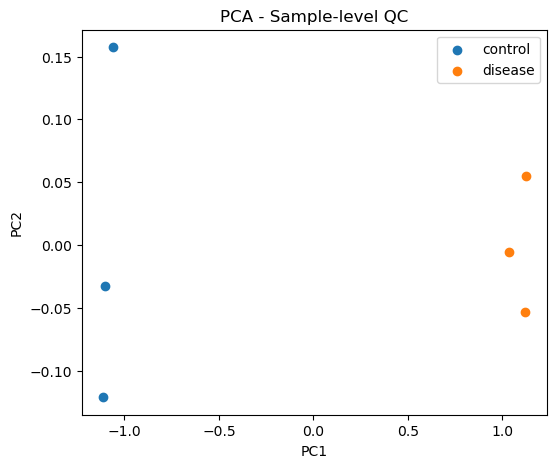

In [33]:
plt.figure(figsize=(6,5))

# Plot samples colored by experimental condition
for condition in pca_df["condition"].unique():
    subset = pca_df[pca_df["condition"] == condition]
    plt.scatter(subset["PC1"], subset["PC2"], label=condition)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - Sample-level QC")
plt.legend()
plt.show()

In [34]:
# Identify control and disease samples using metadata

control_samples = meta[meta["condition"] == "control"].index
disease_samples = meta[meta["condition"] == "disease"].index

control_samples, disease_samples

(Index(['S1', 'S2', 'S3'], dtype='object', name='sample'),
 Index(['S4', 'S5', 'S6'], dtype='object', name='sample'))

In [35]:
# Calculate mean expression for each gene in control samples
control_mean = expr[control_samples].mean(axis=1)

# Calculate mean expression for each gene in disease samples
disease_mean = expr[disease_samples].mean(axis=1)

control_mean.head(), disease_mean.head()

(gene
 TP53     121.666667
 BRCA1     79.000000
 MYC      510.000000
 EGFR     301.666667
 PTEN      61.000000
 dtype: float64,
 gene
 TP53     310.000000
 BRCA1    155.000000
 MYC      896.666667
 EGFR     610.000000
 PTEN      40.000000
 dtype: float64)

In [36]:
# Calculate log2 fold change between disease and control
# +1 avoids division by zero

logFC = np.log2((disease_mean + 1) / (control_mean + 1))

logFC.head()

gene
TP53     1.342171
BRCA1    0.963474
MYC      0.812857
EGFR     1.013443
PTEN    -0.596644
dtype: float64

In [37]:
from scipy.stats import ttest_ind

pvalues = []

# Perform gene-wise statistical testing
for gene in expr.index:
    control_vals = expr.loc[gene, control_samples]
    disease_vals = expr.loc[gene, disease_samples]
    
    stat, pval = ttest_ind(disease_vals, control_vals, equal_var=False)
    pvalues.append(pval)

pvalues[:5]

[np.float64(2.323809050953483e-05),
 np.float64(5.902524500936365e-05),
 np.float64(1.357407086108865e-05),
 np.float64(3.6950842906924083e-06),
 np.float64(0.0026151570200200315)]

In [38]:
# Combine results into a single DataFrame
de_results = pd.DataFrame({
    "gene": expr.index,
    "logFC": logFC.values,
    "pvalue": pvalues
})

de_results.head()

,gene,logFC,pvalue
0,TP53,1.342171,0.000023
1,BRCA1,0.963474,0.000059
2,MYC,0.812857,0.000014
3,EGFR,1.013443,0.000004
4,PTEN,-0.596644,0.002615


In [39]:
# Define significance thresholds
de_results["significant"] = (
    (de_results["pvalue"] < 0.05) &
    (abs(de_results["logFC"]) > 1)
)

de_results

,gene,logFC,pvalue,significant
0,TP53,1.342171,0.000023,True
1,BRCA1,0.963474,0.000059,False
2,MYC,0.812857,0.000014,False
3,EGFR,1.013443,0.000004,True
4,PTEN,-0.596644,0.002615,False
5,GAPDH,0.002400,0.906197,False


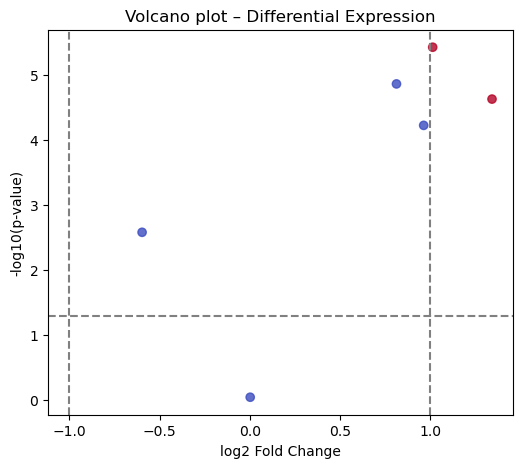

In [40]:
# Add -log10(p-value) for visualization
de_results["neg_log10_p"] = -np.log10(de_results["pvalue"])

plt.figure(figsize=(6, 5))

plt.scatter(
    de_results["logFC"],
    de_results["neg_log10_p"],
    c=de_results["significant"],
    cmap="coolwarm",
    alpha=0.8
)

plt.axvline(x=1, linestyle="--", color="grey")
plt.axvline(x=-1, linestyle="--", color="grey")
plt.axhline(y=1.3, linestyle="--", color="grey")

plt.xlabel("log2 Fold Change")
plt.ylabel("-log10(p-value)")
plt.title("Volcano plot – Differential Expression")

plt.savefig("../results/plots/volcano_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [42]:
# Save differential expression results to CSV
de_results.to_csv(
    "../data/significant_genes.csv",
    index=False
)

In [43]:
# Select significantly differentially expressed genes
significant_genes = de_results[
    (de_results["pvalue"] < 0.05) &
    (abs(de_results["logFC"]) > 1)
][["gene", "logFC", "pvalue"]]

# Save gene list for functional enrichment
significant_genes.to_csv(
    "../data/significant_genes.csv",
    index=False
)

significant_genes

,gene,logFC,pvalue
0,TP53,1.342171,0.000023
3,EGFR,1.013443,0.000004


## Output for functional enrichment

This notebook generates a curated list of significantly differentially
expressed genes based on statistical significance and effect size.
The resulting gene list serves as direct input for downstream
functional enrichment analysis.